In [ ]:
import kapture
import ast
import numpy as np
import numba
import torch
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import os
import ast
import random 
from PIL import Image
from tqdm import tqdm
import cv2
from scipy.spatial.transform import Rotation as R
import re
import math
import copy
import time
import open3d as o3d

import pickle
import json
import shutil
import re
import glob

from mpl_toolkits.mplot3d import axes3d    
import plotly.graph_objects as go

from PIL import Image
from PIL import ImageFont, ImageDraw
import matplotlib.pyplot as plt
from PIL import Image as im



In [3]:
def camera_center_to_translation(c, qvec):
    R = quaternion_to_rotation_matrix(qvec)
    return (-1) * np.matmul(R, c)

def quaternion_to_rotation_matrix(quaternion_wxyz):
    r = R.from_quat([quaternion_wxyz[1], quaternion_wxyz[2], quaternion_wxyz[3], quaternion_wxyz[0]])
    matrix = r.as_matrix()
    matrix[:3,2] = -matrix[:3,2]
    matrix[:3,1] = -matrix[:3,1]
    return matrix

def get_point_3d(x, y, depth, fx, fy, cx, cy, cam_center_world, R_world_to_cam, w_in_quat_first = True):
    if depth <= 0:
        return 0
    new_x = (x - cx)*depth/fx
    new_y = (y - cy)*depth/fy
    new_z = depth
    coord_3D_world_to_cam = np.array([new_x, new_y, new_z], float)
    if len(R_world_to_cam) == 4:
        if w_in_quat_first:
            matrix = quaternion_to_rotation_matrix(R_world_to_cam)
        else:
            R_world_to_cam = [R_world_to_cam[3], R_world_to_cam[0], R_world_to_cam[1], R_world_to_cam[2]]
            matrix = quaternion_to_rotation_matrix(R_world_to_cam)
    coord_3D_cam_to_world = np.matmul(matrix, coord_3D_world_to_cam) + cam_center_world
    return coord_3D_cam_to_world


def clouds3d_from_kpt(path):
    filedict = open(path, 'r')
    dict_string = json.load(filedict)
    ast.literal_eval(dict_string)  
    kpt_coord = ast.literal_eval(dict_string)
    
    points_db = []
    points_query = []
    for mode in kpt_coord.keys():
        for triple in kpt_coord[mode]:
            x, y, depth_point = triple
            if depth_point > 0 and not (math.isnan(depth_point) or (math.isinf(depth_point))): 
                point_3d_xyz = cloud_3d_cam(x, y, depth_point)
                
            else:
                continue
            if mode == list(kpt_coord.keys())[0]:
                points_query.append(list(point_3d_xyz))
            else:
                points_db.append(list(point_3d_xyz))

    size = min(len(points_query), len(points_db))
    points_3d_query = np.empty((3, size), float)
    points_3d_mapping = np.empty((3, size), float)
    for i in range(size):
        points_3d_query[:,i] = points_query[i]
        points_3d_mapping[:,i] = points_db[i]
    
    return points_3d_query, points_3d_mapping

def get_angular_error(R_exp, R_est):
    """
    Calculate angular error
    """
    return abs(np.arccos(min(max(((np.matmul(R_exp.T, R_est)).trace() - 1) / 2, -1.0), 1.0)));

def cloud_3d_cam(x, y, depth, fx = 128, fy = 128, cx = 128, cy = 128):
    if depth <= 0:
        return 0
    new_x = (x - cx)*depth/fx
    new_y = (y - cy)*depth/fy
    new_z = depth
    coord_3D_world_to_cam = np.array([new_x, new_y, new_z], float)
    return coord_3D_world_to_cam

def is_invertible(a):
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

In [ ]:
import kapture
import ast
import numpy as np
import numba
import torch
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import os
import random 
from PIL import Image
from tqdm import tqdm
import cv2
from scipy.spatial.transform import Rotation as R
import math
import copy
import time
import open3d as o3d
import pickle
import json
import shutil
import re
import glob
from mpl_toolkits.mplot3d import axes3d    
import plotly.graph_objects as go
from PIL import ImageFont, ImageDraw
import matplotlib.pyplot as plt
from PIL import Image as im



# Downloading of dataset

In [ ]:
!python download_dataset.py

# Preprocessing stage

In [ ]:
input_dir = 'path/to/HPoint_loc_datasets'

dataset_path = os.path.join(input_dir, 'extracted_Habitat')
shutil.rmtree(dataset_path, ignore_errors=True) 

query_path = os.path.join(dataset_path, 'query')
os.makedirs(query_path, exist_ok=True)
database_path = os.path.join(dataset_path, 'mapping')
os.makedirs(database_path, exist_ok=True)

data_logs = ['sensors.txt', 'trajectories.txt,' 'records_camera.txt', 'records_depth.txt']


In [ ]:
global_counter_query = 0
global_counter_db = 0
w, h, fx, fy, cx, cy = 256, 256, 128, 128, 128, 128
count = 0
os.makedirs('assets', exist_ok=True)
for map_name in tqdm(os.listdir(input_dir)):
    if map_name.find('.') != -1:
        continue
    
    for hdf5_dataset in sorted(os.listdir(os.path.join(input_dir, map_name))):
        if hdf5_dataset.find('.hdf5') == -1:
            continue
    
        hdf5_dataset_path = os.path.join(input_dir, map_name, hdf5_dataset)
        file = h5py.File(hdf5_dataset_path, 'r')
        rgb_base = file['rgb_base']
        depth_base = file['depth_base']
        gps_base = file['gps_base']
        quat_base = file['quat_base']
        rgb = file['rgb']
        depth = file['depth']
        gps = file['gps']
        quat = file['quat']
        num_cloud = re.findall(r'\d+', hdf5_dataset)[-2]
        
        semantic_base = file['semantic_base']
        
        output_query_path_images = os.path.join(query_path, 'sensors', 'records_data', map_name, str(num_cloud))
        os.makedirs(output_query_path_images, exist_ok=True)
        output_database_path_images = os.path.join(database_path, 'sensors', 'records_data',  map_name, str(num_cloud))
        os.makedirs(output_database_path_images, exist_ok=True)
        
        for num_query in range(len(rgb)):
            with open(query_path + '/sensors.txt', 'a') as fin:
                fin.write(f'sensor{global_counter_query}, ,camera, PINHOLE, {w}, {h}, {fx}, {fy}, {cx}, {cy}\n')
              
            with open(query_path + '/trajectories.txt', 'a') as fin:
                qw, qx, qy, qz = quat[num_query]
                tx, ty, tz =  gps[num_query]
                fin.write(f'{global_counter_query}, sensor{global_counter_query}, {qw}, {qx}, {qy}, {qz}, {tx}, {ty}, {tz}\n')
            
            with open(query_path + '/records_camera.txt', 'a') as fin:
                fin.write(f'{global_counter_query}, sensor{global_counter_query}, {map_name}/{num_cloud}/query_{str(num_query).zfill(4)}.png\n')
                
            
            with open(query_path + '/records_depth.txt', 'a') as fin:
                fin.write(f'{global_counter_query}, sensor{global_counter_query}, {map_name}/{num_cloud}/query_{str(num_query).zfill(4)}.npy\n')
                
            cv2.imwrite(os.path.join(output_query_path_images, 'query_' + str(num_query).zfill(4) + '.png'), cv2.cvtColor(rgb[num_query], cv2.COLOR_RGB2BGR))
            np.save(os.path.join(output_query_path_images, 'query_' + str(num_query).zfill(4) + '.png'), depth[num_query])

            global_counter_query += 1

        for num_base in range(len(rgb_base)):
            with open(database_path + '/sensors.txt', 'a') as fin:
                fin.write(f'sensor{global_counter_db}, ,camera, PINHOLE, {w}, {h}, {fx}, {fy}, {cx}, {cy}\n')
              
            with open(database_path + '/trajectories.txt', 'a') as fin:
                qw, qx, qy, qz = quat_base[num_base]
                tx, ty, tz =  gps_base[num_base]
                fin.write(f'{global_counter_db}, sensor{global_counter_db}, {qw}, {qx}, {qy}, {qz}, {tx}, {ty}, {tz}\n')
            
            with open(database_path + '/records_camera.txt', 'a') as fin:
                fin.write(f'{global_counter_db}, sensor{global_counter_db}, {map_name}/{num_cloud}/mapping_{str(num_base).zfill(4)}.png\n')
                
            
            with open(database_path + '/records_depth.txt', 'a') as fin:
                fin.write(f'{global_counter_db}, sensor{global_counter_db}, {map_name}/{num_cloud}/mapping_{str(num_base).zfill(4)}.npy\n')
                   
            cv2.imwrite(os.path.join(output_database_path_images, 'mapping_' + str(num_base).zfill(4) + '.png'), cv2.cvtColor(rgb_base[num_base], cv2.COLOR_RGB2BGR))
            np.save(os.path.join(output_database_path_images, 'mapping_' + str(num_base).zfill(4) + '.png'), depth_base[num_base])
            global_counter_db += 1

    
            cv2.imwrite(os.path.join('assets', map_name + '_point' + num_cloud, str(num_base).zfill(4) + '.png'), cv2.cvtColor(rgb_base[num_base], cv2.COLOR_RGB2BGR)) 
            

In [ ]:
#pip installing frameworks
#
#
#
#

# AP-GeM

In [ ]:
pretrained_model = '/Resnet101-AP-GeM-LM18.pt'

%cd /home/musaev_rv/Myfolder/repo/deep-image-retrieval
!python3 -m dirtorch.extract_kapture --kapture-root $database_path --checkpoint $pretrained_model --gpu 0
!python3 -m dirtorch.extract_kapture --kapture-root $query_path --checkpoint $pretrained_model  --gpu 0
%cd /home/musaev_rv/Myfolder

# Kapture compute image pairs

In [ ]:
import os
query_path = '/home/musaev_rv/data/extracted_Habitat/query'
database_path = '/home/musaev_rv/data/extracted_Habitat/mapping'
kapture_dir = '/home/musaev_rv/Myfolder'

method = 'AP_GeM'
path = os.path.join(kapture_dir, method)
outpath = f'{path}_top1.txt'

%cd /home/musaev_rv/Myfolder/repo/kapture-localization/tools
!python3 kapture_compute_image_pairs.py --query /home/musaev_rv/data/extracted_Habitat/query --mapping /home/musaev_rv/data/extracted_Habitat/mapping -o /home/musaev_rv/Myfolder/outpath.txt --topk 1 
%cd /home/musaev_rv/Myfolder/

In [ ]:
query_path = '/home/musaev_rv/data/extracted_Habitat/query'
database_path = '/home/musaev_rv/data/extracted_Habitat/mapping'
kapture_dir = '/home/musaev_rv/Myfolder'

method = 'AP_GeM'
path = os.path.join(kapture_dir, method)
outpath = f'{path}_top1.txt'

%cd /home/musaev_rv/Myfolder/repo/kapture-localization/tools
!python3 kapture_compute_image_pairs.py --query /home/musaev_rv/Myfolder/habitat/query  --mapping /home/musaev_rv/Myfolder/habitat/mapping -o /home/musaev_rv/Myfolder/outpath.txt --topk 1
%cd /home/musaev_rv/Myfolder/

# NetVLAD, HF-NET

In [ ]:
downloading from gdrive
root_dir = '/home/musaev_rv/data'
%cd $root_dir
!bash download_data.sh

s = 'feats-superpoint-n4096-r1024-nms4_matches-superglue_NetVLAD_all_maps_top_1.h5'
d = 'feats-superpoint-n4096-r1024-nms4_matches-superglue_NetVLAD_all_maps_top1.h5'
d = os.path.join(kapture_dir, d)
!mv $s $d

s = 'feats-superpoint-n4096-r1024-nms4_matches-superglue_HF-Net_all_maps_top1.h5'
d = os.path.join(kapture_dir, s)
!mv $s  $d

s = 'feats-superpoint-n4096-r1024-nms4.h5'
d = os.path.join(kapture_dir, s)
!mv $s  $d

#writing .txt file
image_retrieval_methods = {'netvlad' : 'NetVLAD', 'hfnet': 'HF-Net'}
method = image_retrieval_methods[option]

input_dir = '/home/musaev_rv/data/Habitat'
kapture_dir = '/home/musaev_rv/data/extracted_Habitat'
mapslist = os.listdir(input_dir)

for option in tqdm(image_retrieval_methods.keys()):
    method = image_retrieval_methods[option]
    match_filename = f'feats-superpoint-n4096-r1024-nms4_matches-superglue_{method}_all_maps_top1.h5'
    match_file = h5py.File(os.path.join(kapture_dir, match_filename), 'r')
    pairs = list(map(lambda pair: ('_'.join(pair.split('_')[:4]), '_'.join(pair.split('_')[4:])), list(match_file.keys()))) 
    with open(f'/home/musaev_rv/Myfolder/{method}_top1.txt', 'w') as fin:
        fin.write('# kapture format: 1.1\n')
        fin.write('# query_image, map_image, score\n')
        for pair in pairs:
            q, m = pair
            q_fold, q_name = q.split('_')[0], '_'.join(q.split('_')[1:])
            m_fold, m_name = m.split('_')[0], '_'.join(m.split('_')[1:]) 

            r = re.compile(f".*{q_fold}")
            q_fold = list(filter(r.match, mapslist))[0]
            r = re.compile(f".*{m_fold}")
            m_fold = list(filter(r.match, mapslist))[0]
            q = '_'.join([q_fold, q_name])
            m = '_'.join([m_fold, m_name])
            q = re.sub(r'_', '/', re.sub(r'point', r'' , q), count = 2)
            m = re.sub(r'_', '/', re.sub(r'point', r'' , m), count = 2)
            m = re.sub('database', 'mapping', m)
            string = q + '.png, ' + m + '.png, ' + '1\n'
            fin.write(string)

# HF-NET, NetVLAD - Time measuring

In [34]:
!python /home/musaev_rv/Myfolder/repo/hfnet/hfnet/time_model.py hfnet/configs/[hfnet|superpoint]_export_[aachen|cmu|robotcar]_db.yaml --image --input_size 256 --use_cpu False

/bin/bash: superpoint]_export_[aachen: command not found
/bin/bash: robotcar]_db.yaml: command not found
/bin/bash: cmu: command not found
2021-08-14 14:35:19.691934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-14 14:35:19.691961: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Traceback (most recent call last):
  File "/home/musaev_rv/Myfolder/repo/hfnet/hfnet/time_model.py", line 9, in <module>
    tf.contrib.resampler  # import C++ op
AttributeError: module 'tensorflow' has no attribute 'contrib'


In [ ]:
!python /home/musaev_rv/Myfolder/repo/hfnet/hfnet/time_model.py hfnet/configs/netvlad_export_[aachen|cmu|robotcar].yaml --image --input_size 256 --use_cpu False

# Patch-NetVLAD

In [ ]:
#writing .txt file
for mode in ['query', 'mapping']:
    path_txt = f'/home/musaev_rv/data/extracted_Habitat/{mode}_patchvlad.txt'
    fout = open(path_txt, 'w')
    path_records_data = f'/home/musaev_rv/data/extracted_Habitat/{mode}/sensors/records_camera.txt'
    with open(path_records_data, 'r') as fin:
        for string in fin:
            path_kapture = f'/home/musaev_rv/data/extracted_Habitat/{mode}/sensors/records_data'
            string = os.path.join(path_kapture, string.split(', ')[2])
            print(string)
            fout.write(string)

    fout.close()

In [ ]:
%cd /home/musaev_rv/Myfolder/repo/Patch-NetVLAD
!python feature_extract.py \
   --config_path patchnetvlad/configs/speed.ini \
   --dataset_file_path=/home/musaev_rv/Myfolder/mapping_patchvlad.txt \
   --dataset_root_dir=/home/musaev_rv/data/extracted_Habitat \
   --output_features_dir /home/musaev_rv/data/extracted_Habitat/mapping/reconstruction/global_features


In [ ]:
%cd /home/musaev_rv/Myfolder/repo/Patch-NetVLAD
!python feature_extract.py \
   --config_path patchnetvlad/configs/speed.ini \
   --dataset_file_path=/home/musaev_rv/Myfolder/query_patchvlad.txt \
   --dataset_root_dir=/home/musaev_rv/data/extracted_Habitat \
   --output_features_dir /home/musaev_rv/data/extracted_Habitat/query/reconstruction/global_features

In [ ]:
%cd /home/musaev_rv/Myfolder/repo/Patch-NetVLAD
!python feature_match.py \
  --config_path patchnetvlad/configs/speed.ini \
  --dataset_root_dir=/home/musaev_rv/data/extracted_Habitat \
  --query_file_path=/home/musaev_rv/Myfolder/query_patchvlad.txt \
  --index_file_path=/home/musaev_rv/Myfolder/mapping_patchvlad.txt \
  --query_input_features_dir /home/musaev_rv/data/extracted_Habitat/query/reconstruction/global_features \
  --index_input_features_dir /home/musaev_rv/data/extracted_Habitat/mapping/reconstruction/global_features \
  --result_save_folder /home/musaev_rv/data/extracted_Habitat/patch_result_speed_new

In [ ]:
pairs = []
mode = 'speed'
path_im_retrieval = f'/home/musaev_rv/data/extracted_Habitat/patch_result_{mode}/PatchNetVLAD_predictions.txt'
final_top1_path = f'/home/musaev_rv/Myfolder/PatchNetVLAD(s)_top1.txt'
fin = open(final_top1_path,'w')
fin.write('# kapture format: 1.1\n')
fin.write('# query_image, map_image, score\n')

with open(path_im_retrieval, 'r') as fout:
    for line in fout.readlines()[2::100]:
        query_string, mapping_string = map(lambda x: x.split('\n')[0], line.split(', ')) 
        query_string = '/'.join(query_string.split('/')[8:])
        mapping_string = '/'.join(mapping_string.split('/')[8:]).split('\n')[0]
        string = query_string + ', ' + mapping_string + ', 1\n'
        fin.write(string)  
        
fin.close()


# R2D2_extraction

In [ ]:
pretrained_model = '/home/musaev_rv/Myfolder/repo/r2d2/models/r2d2_WASF_N8_big.pt'
!python3 /home/musaev_rv/Myfolder/repo/r2d2/extract_kapture.py --kapture-root $database_path --model $pretrained_model --top-k 1000 --gpu 0 --min-size 0 --max-size 256 --min-scale 0.3 --max-scale 1.0;
!python3 /home/musaev_rv/Myfolder/repo/r2d2/extract_kapture.py --kapture-root $query_path --model $pretrained_model --top-k 1000 --gpu 0 --min-size 0 --max-size 256 --min-scale 0.3 --max-scale 1.0;

# R2D2_matching

In [38]:
!python3 /home/musaev_rv/Myfolder/repo/kapture-localization/tools/kapture_compute_matches.py -i /home/musaev_rv/data/extracted_Habitat/map_plus_query --pairsfile-path /home/musaev_rv/Myfolder/PatchNetVLAD(s)_top1.txt

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `python3 /home/musaev_rv/Myfolder/repo/kapture-localization/tools/kapture_compute_matches.py -i /home/musaev_rv/data/extracted_Habitat/map_plus_query --pairsfile-path /home/musaev_rv/Myfolder/PatchNetVLAD(s)_top1.txt'


In [37]:
option = 'patchnetvlad_s'
image_retrieval_methods = {'netvlad' : 'NetVLAD', 'hfnet': 'HF-Net', 'apgem': 'AP-GeM', 'patchnetvlad_s': 'PatchNetVLAD(s)'}
method = image_retrieval_methods[option]

final_image_retrieval_path = f'/home/musaev_rv/Myfolder/{method}_top1.txt'
!python /home/musaev_rv/Myfolder/repo/kapture/tools/kapture_merge.py -i /home/musaev_rv/data/extracted_Habitat/query /home/musaev_rv/data/extracted_Habitat/mapping -o /home/musaev_rv/data/extracted_Habitat/map_plus_query -y

!python3 /home/musaev_rv/Myfolder/repo/kapture-localization/tools/kapture_compute_matches.py -i /home/musaev_rv/data/extracted_Habitat/map_plus_query --pairsfile-path $final_image_retrieval_path


/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `python3 /home/musaev_rv/Myfolder/repo/kapture-localization/tools/kapture_compute_matches.py -i /home/musaev_rv/data/extracted_Habitat/map_plus_query --pairsfile-path /home/musaev_rv/Myfolder/PatchNetVLAD(s)_top1.txt'


# R2D2 - postprocessing

In [ ]:
# везде повторяется, сделать функцией

input_dir = '/home/musaev_rv/data/Habitat'
option = 'hfnet'
image_retrieval_methods = {'netvlad' : 'NetVLAD', 'hfnet': 'HF-Net', 'apgem': 'AP-GeM', 'patchnetvlad_s': 'PatchNetVLAD_s'}
method = image_retrieval_methods[option]

records_data_path = '/home/musaev_rv/data/extracted_Habitat/query/sensors/records_data/'
records_data_depth = '/home/musaev_rv/data/extracted_Habitat/query/sensors/depth/'

merged_path = '/home/musaev_rv/data/extracted_Habitat/map_plus_query/reconstruction/'
matches_path = 'matches/r2d2_WASF_N8_big/*/*/query*/*/*/'
keypoints_path = 'keypoints/r2d2_WASF_N8_big/'
output_dir = f'/home/musaev_rv/data/extracted_Habitat/map_plus_query/reconstruction/{method}_r2d2'

shutil.rmtree(output_dir, ignore_errors=True)
os.mkdir(output_dir)

matches_path = os.path.join(merged_path, matches_path)
keypoints_path = os.path.join(merged_path, keypoints_path)

for dataset in tqdm(glob.glob(matches_path)):
    overlaps = sorted(os.listdir(dataset))
    for path in tqdm(overlaps):
        string = os.path.join(dataset, path)
        query_name = string.split('/')[9:12] #parse names of query and mapping
        query_name = '.'.join('/'.join(query_name).split('.')[:-1])
        
        mapping_name = string.split('/')[12:15]
        mapping_name = '.'.join('/'.join(mapping_name).split('.')[:-1])
                
        q_fold, q_cloud, q_name = query_name.split('/')                    
        m_fold, m_cloud, m_name = mapping_name.split('/') 
        
        q = q_fold + '_' + re.sub(r'point', r'' , q_cloud) + '_' + q_name
        m = m_fold + '_' + re.sub(r'point', r'' , m_cloud) + '_' + m_name

        q_cloud = q_fold + '_point' + q_cloud + '.hdf5'
        m_cloud = m_fold + '_point' + m_cloud + '.hdf5'

        hdf5_q_path = os.path.join(input_dir, q_fold, q_cloud)
        hdf5_m_path = os.path.join(input_dir, m_fold, m_cloud)
        #print(hdf5_q_path, hdf5_m_path)
        q_name = int(re.findall(r'\d+', q_name)[0])
        m_name = int(re.findall(r'\d+', m_name)[0])

        q_file = h5py.File(hdf5_q_path, 'r')
        m_file = h5py.File(hdf5_m_path, 'r')

        depth_base = m_file['depth_base']
        depth = q_file['depth']

        q_depth = np.squeeze(depth[q_name])
        m_depth = np.squeeze(depth_base[m_name])
        
        #opening of .kpt files according to q_name, m_name:
        q_kpt_file =  keypoints_path + query_name +'.kpt'
        m_kpt_file =  keypoints_path + mapping_name +'.kpt'
        
        q_kpt = np.fromfile(q_kpt_file, dtype = np.float32).reshape((-1,3))
        m_kpt = np.fromfile(m_kpt_file, dtype = np.float32).reshape((-1,3))

        matches = np.fromfile(string, dtype = np.float64).reshape((-1,3)) 
        q_coord_frame = []
        m_coord_frame = []
        for kpt in range(matches.shape[0]): 
            x_q, y_q, _ = map(int, q_kpt[int(matches[kpt][0])])
            x_m, y_m, _ = map(int, m_kpt[int(matches[kpt][1])])

            q_coord_frame.append((x_q, y_q, q_depth[y_q, x_q]))
            m_coord_frame.append((x_m, y_m, m_depth[y_m, x_m]))

        dictionary_kpt = {q: q_coord_frame, m:m_coord_frame}
        outpath = os.path.join(output_dir, q + '_' +  m + '.json')
        with open(outpath, 'w') as outfile:
            json.dump(str(dictionary_kpt), outfile)



# Superglue (HF-NET/NETVLAD)

In [ ]:
#writing {method}_superglue.json
import h5py
image_retrieval_methods = {'netvlad' : 'NetVLAD', 'hfnet': 'HF-Net'}
input_dir = '/home/musaev_rv/data/Habitat'
mapslist = os.listdir(input_dir)
kapture_dir = '/home/musaev_rv/data/extracted_Habitat'
filepath = 'feats-superpoint-n4096-r1024-nms4.h5'
feature_filename =  os.path.join(kapture_dir, filepath)

for option in image_retrieval_methods.keys():
    method = image_retrieval_methods[option]
    keypoints_file = h5py.File(feature_filename, 'r')
    match_filename = f'feats-superpoint-n4096-r1024-nms4_matches-superglue_{method}_all_maps_top1.h5'
    match_file = h5py.File(os.path.join(kapture_dir, match_filename), 'r')
    
    output_dir = f'/home/musaev_rv/data/extracted_Habitat/map_plus_query/reconstruction/{method}_superglue'
    shutil.rmtree(output_dir, ignore_errors=True) 
    os.mkdir(output_dir)
    for pair_mtch in tqdm(list(match_file.keys())):
        matches_list = match_file[pair_mtch]['matches0'].__array__()
        query, mapping =  '_'.join(pair_mtch.split('_')[:4]), '_'.join(pair_mtch.split('_')[4:])  
        
        kpt_query = keypoints_file[query]['keypoints'].__array__()
        kpt_mapping = keypoints_file[mapping]['keypoints'].__array__()
        
        q_fold, q_cloud, _ , q_name = query.split('_')
        m_fold, m_cloud, _ , m_name = mapping.split('_')

        r = re.compile(f".*{q_fold}")
        q_fold = list(filter(r.match, mapslist))[0]
        r = re.compile(f".*{m_fold}")
        m_fold = list(filter(r.match, mapslist))[0]

        q = q_fold + '_' + re.sub(r'point', r'' , q_cloud) + '_query_' + q_name
        m = m_fold + '_' + re.sub(r'point', r'' , m_cloud) + '_mapping_' + m_name

        q_cloud = q_fold + '_' + q_cloud + '.hdf5'    
        m_cloud = m_fold + '_' + m_cloud + '.hdf5'

        hdf5_q_path = os.path.join(input_dir, q_fold, q_cloud)
        hdf5_m_path = os.path.join(input_dir, m_fold, m_cloud)

        q_name = int(re.findall(r'\d+', q_name)[0])
        m_name = int(re.findall(r'\d+', m_name)[0])

        q_file = h5py.File(hdf5_q_path, 'r')
        m_file = h5py.File(hdf5_m_path, 'r')

        depth_base = m_file['depth_base']
        depth = q_file['depth']

        q_depth = np.squeeze(depth[q_name])
        m_depth = np.squeeze(depth_base[m_name])

        q_coord_frame = []
        m_coord_frame = []

        for kpt in range(min(matches_list.shape[0], kpt_mapping.shape[0])): 
            if matches_list[kpt] != -1:
                x_m, y_m = map(int, kpt_mapping[matches_list[kpt]])
                x_q, y_q = map(int, kpt_query[kpt])

                q_coord_frame.append((x_q, y_q, q_depth[y_q, x_q]))
                m_coord_frame.append((x_m, y_m, m_depth[y_m, x_m]))

        dictionary_kpt = {q: q_coord_frame, m:m_coord_frame}
        outpath = os.path.join(output_dir, q + '.png_'  + m + '.png.json')
        with open(outpath, 'w') as outfile:
            json.dump(str(dictionary_kpt), outfile)


In [ ]:
import h5py

feature_filename =  'feats-superpoint-n4096-r1024-nms4.h5'
keypoints_file = h5py.File(str(outputs / feature_filename), 'r')

match_filename = 'feats-superpoint-n4096-r1024-nms4_matches-superglue_NetVLAD_query_top_40.h5'
match_file = h5py.File(str(outputs / match_filename), 'r')

keypoints = keypoints_file[filename]

matches = match_file[filename1_filename2]

# Superglue 

In [61]:
!rm '/home/musaev_rv/Myfolder/PatchNetVLAD_s_superglue_top1.txt'
fin = open('/home/musaev_rv/Myfolder/PatchNetVLAD_s_superglue_top1.txt', 'a')
with open('/home/musaev_rv/Myfolder/PatchNetVLAD_s_top1.txt','r') as fout:
    for l in fout.readlines()[2:]:
        q, m, score = l.split(', ')
        q = 'extracted_Habitat/query/sensors/records_data/'+ q
        m = 'extracted_Habitat/mapping/sensors/records_data/'+ m + '\n'
        fin.write(' '.join([q, m]))
fin.close()

In [ ]:
input_dir = '/home/musaev_rv/data/Habitat'
option = 'patchnetvlad_s'
image_retrieval_methods = {'netvlad' : 'NetVLAD', 'hfnet': 'HF-Net', 'apgem': 'AP-GeM', 'patchnetvlad_s': 'PatchNetVLAD_s'}
method = image_retrieval_methods[option]

!rm -rf $output_dir
output_dir = f'/home/musaev_rv/data/extracted_Habitat/map_plus_query/reconstruction/{method}_superglue_proxy'
    !python3 /home/musaev_rv/Myfolder/repo/SuperGluePretrainedNetwork/match_pairs.py --input_pairs '/home/musaev_rv/Myfolder/PatchNetVLAD_s_superglue_top1.txt' --input_dir '/home/musaev_rv/data/' --resize -1 --output_dir $output_dir

In [66]:
input_dir = '/home/musaev_rv/data/Habitat'
option = 'patchnetvlad_s'
image_retrieval_methods = {'netvlad' : 'NetVLAD', 'hfnet': 'HF-Net', 'apgem': 'AP-GeM', 'patchnetvlad_s': 'PatchNetVLAD_s'}
method = image_retrieval_methods[option]
output_dir = f'/home/musaev_rv/data/extracted_Habitat/map_plus_query/reconstruction/{method}_superglue_proxy'

path = f'/home/musaev_rv/data/extracted_Habitat/map_plus_query/reconstruction/{method}_superglue_proxy'
input_dir = '/home/musaev_rv/data/Habitat'
pairs_npz = os.listdir(output_dir) 
mapslist = os.listdir(input_dir)
output_dir = f'/home/musaev_rv/data/extracted_Habitat/map_plus_query/reconstruction/{method}_superglue'

!rm -rf $output_dir
os.mkdir(output_dir)
for pair_npz in tqdm(pairs_npz):
    npz = np.load(os.path.join(path, pair_npz))
    query, mapping = '_'.join(pair_npz.split('_')[:4]), '_'.join(pair_npz.split('_')[4:8])

    q_fold, q_cloud, _ , q_name = query.split('_')
    m_fold, m_cloud, _ , m_name = mapping.split('_')

    q_cloud = q_fold + '_point' + q_cloud  + '.hdf5'
    m_cloud = m_fold + '_point' + m_cloud  + '.hdf5'

    hdf5_q_path = os.path.join(input_dir, q_fold, q_cloud)
    hdf5_m_path = os.path.join(input_dir, m_fold, m_cloud)

    q_name = int(re.findall(r'\d+', q_name)[0])
    m_name = int(re.findall(r'\d+', m_name)[0])


    q_file = h5py.File(hdf5_q_path, 'r')
    m_file = h5py.File(hdf5_m_path, 'r')

    depth_base = m_file['depth_base']
    depth = q_file['depth']
    
    q_depth = np.squeeze(depth[q_name])
    m_depth = np.squeeze(depth_base[m_name])
    
    q_coord_frame = []
    m_coord_frame = []
    for kpt in range(min(npz['keypoints1'].shape[0], npz['matches'].shape[0])): 
        if npz['matches'][kpt] != -1:
            x_q, y_q = map(int, npz['keypoints0'][kpt])
            x_m, y_m = map(int, npz['keypoints1'][npz['matches'][kpt]])
            
            q_coord_frame.append((x_q, y_q, q_depth[y_q, x_q]))
            m_coord_frame.append((x_m, y_m, m_depth[y_m, x_m]))
  
    dictionary_kpt = {q: q_coord_frame, m:m_coord_frame}
    outpath = os.path.join(output_dir, query.replace('/','_') + '_' + mapping.replace('/','_') + '.json')
    with open(outpath, 'w') as outfile:
        json.dump(str(dictionary_kpt), outfile)

100%|██████████| 76136/76136 [2:34:47<00:00,  8.20it/s]  


# LoFTR

In [ ]:
%cd /home/musaev_rv/Myfolder/repo/LoFTR/src
import os
os.chdir("..")
import torch
import numpy as np
import matplotlib.cm as cm
import random
import re
import cv2
import json  
from src.loftr import LoFTR, default_cfg

input_dir = '/home/musaev_rv/data/Habitat'
option = 'patchnetvlad_s'
image_retrieval_methods = {'netvlad' : 'NetVLAD', 'hfnet': 'HF-Net', 'apgem': 'AP-GeM', 'patchnetvlad_s': 'PatchNetVLAD_s'}
method = image_retrieval_methods[option]

matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("/home/musaev_rv/Myfolder/indoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

output_dir = f'/home/musaev_rv/data/extracted_Habitat/map_plus_query/reconstruction/{method}_loftr'
!rm -rf $output_dir
os.mkdir(output_dir)

with open(f'/home/musaev_rv/Myfolder/{method}_top1.txt', 'r') as f:
    print(f'Loftr processing on {method} image pairs...')
    for pair in tqdm(f.readlines()[2:]):

        q, m, score = pair.split(', ') 
        q_fold, q_cloud, q_name = q.split('/')
        m_fold, m_cloud, m_name = m.split('/')

        q_cloud = q_fold + '_point' + q_cloud + '.hdf5'
        m_cloud = m_fold + '_point' + m_cloud + '.hdf5'
        
        hdf5_q_path = os.path.join(input_dir, q_fold, q_cloud)
        hdf5_m_path = os.path.join(input_dir, m_fold, m_cloud)
        q_name = int(re.findall(r'\d+', q_name)[0])
        m_name = int(re.findall(r'\d+', m_name)[0])

        q_file = h5py.File(hdf5_q_path, 'r')
        m_file = h5py.File(hdf5_m_path, 'r')
        
        rgb_base = m_file['rgb_base']
        depth_base = m_file['depth_base']
        rgb = q_file['rgb']
        depth = q_file['depth']

        img0_raw = np.squeeze(rgb[q_name])[:,:,0]
        img1_raw = np.squeeze(rgb_base[m_name])[:,:,0]
        q_depth = np.squeeze(depth[q_name])
        m_depth = np.squeeze(depth_base[m_name])

        img0 = torch.from_numpy(img0_raw)[None][None].cuda()/255.
        img1 = torch.from_numpy(img1_raw)[None][None].cuda()/255.
        batch = {'image0': img0, 'image1': img1}

        with torch.no_grad():
            matcher(batch)
            mkpts0 = batch['mkpts0_f'].cpu().numpy()
            mkpts1 = batch['mkpts1_f'].cpu().numpy()
            mconf = batch['mconf'].cpu().numpy()

        q_kpt = mkpts0
        m_kpt = mkpts1
        q_coord_frame = []
        m_coord_frame = []
        for j in range(m_kpt.shape[0]): # собираем все заматченные кипоинты
            x_m, y_m = map(int, m_kpt[j])
            x_q, y_q = map(int, q_kpt[j])

            q_coord_frame.append((x_q, y_q, q_depth[y_q, x_q]))
            m_coord_frame.append((x_m, y_m, m_depth[y_m, x_m]))

        dictionary_kpt = {q: q_coord_frame, m:m_coord_frame}
        outpath = os.path.join(output_dir, q.replace('/','_') + '_' + m.replace('/','_') + '.json')
        with open(outpath, 'w') as outfile:
            json.dump(str(dictionary_kpt), outfile)


In [ ]:
%cd /home/musaev_rv/Myfolder/repo/LoFTR/src
import os
os.chdir("..")
import torch
import numpy as np
import matplotlib.cm as cm
import random
import re
import cv2
import json  
from src.loftr import LoFTR, default_cfg

input_dir = '/home/musaev_rv/data/Habitat'
option = 'netvlad'
image_retrieval_methods = {'netvlad' : 'NetVLAD', 'hfnet': 'HF-Net', 'apgem': 'AP-GeM', 'patchnetvlad': 'PatchNetVLAD_s'}
method = image_retrieval_methods[option]

matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("/home/musaev_rv/Myfolder/indoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

output_dir = f'/home/musaev_rv/data/extracted_Habitat/map_plus_query/reconstruction/{method}_loftr'
!rm -rf $output_dir
os.mkdir(output_dir)
with open(f'/home/musaev_rv/Myfolder/{method}_top1.txt', 'r') as f:
    print(f'Loftr processing on {method} image pairs...')
    for pair in tqdm(f.readlines()[2:]):
        q, m, score = pair.split(', ')
        
        q_fold, q_cloud, q_name = q.split('/')
        m_fold, m_cloud, m_name = m.split('/')

        q_cloud = q_fold + '_point' + q_cloud + '.hdf5'
        m_cloud = m_fold + '_point' + m_cloud + '.hdf5'
        
        hdf5_q_path = os.path.join(input_dir, q_fold, q_cloud)
        hdf5_m_path = os.path.join(input_dir, m_fold, m_cloud)
        q_name = int(re.findall(r'\d+', q_name)[0])
        m_name = int(re.findall(r'\d+', m_name)[0])

        q_file = h5py.File(hdf5_q_path, 'r')
        m_file = h5py.File(hdf5_m_path, 'r')
        
        rgb_base = m_file['rgb_base']
        depth_base = m_file['depth_base']
        rgb = q_file['rgb']
        depth = q_file['depth']

        img0_raw = np.squeeze(rgb[q_name])[:,:,0]
        img1_raw = np.squeeze(rgb_base[m_name])[:,:,0]
        q_depth = np.squeeze(depth[q_name])
        m_depth = np.squeeze(depth_base[m_name])

        img0 = torch.from_numpy(img0_raw)[None][None].cuda()/255.
        img1 = torch.from_numpy(img1_raw)[None][None].cuda()/255.
        batch = {'image0': img0, 'image1': img1}

        with torch.no_grad():
            matcher(batch)
            mkpts0 = batch['mkpts0_f'].cpu().numpy()
            mkpts1 = batch['mkpts1_f'].cpu().numpy()
            mconf = batch['mconf'].cpu().numpy()

        q_kpt = mkpts0
        m_kpt = mkpts1
        q_coord_frame = []
        m_coord_frame = []
        for j in range(m_kpt.shape[0]): # собираем все заматченные кипоинты
            x_m, y_m = map(int, m_kpt[j])
            x_q, y_q = map(int, q_kpt[j])

            q_coord_frame.append((x_q, y_q, q_depth[y_q, x_q]))
            m_coord_frame.append((x_m, y_m, m_depth[y_m, x_m]))

        dictionary_kpt = {q: q_coord_frame, m:m_coord_frame}
        outpath = os.path.join(output_dir, q.replace('/','_') + '_' + m.replace('/','_') + '.json')
        with open(outpath, 'w') as outfile:
            json.dump(str(dictionary_kpt), outfile)


# Validation of optimization on random pair  (TEASER++)

/home/musaev_rv/Myfolder/repo/TEASER-plusplus/build/python
PatchNetVLAD(s) + R2D2 + Teaser++ (>5 matches)


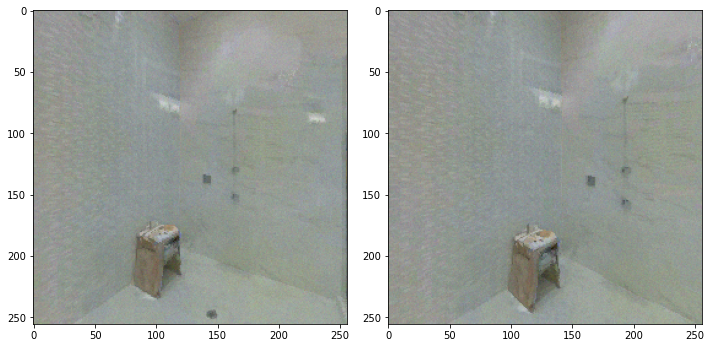

In [88]:
#seed_value = 15
#random.seed(seed_value)

image_retrieval = 'patchnetvlad_s'
title_method = {'patchnetvlad_s+loftr': 'PatchNetVLAD(s) + LoFTR + Teaser++ (>5 matches)', 'patchnetvlad_s+superglue': 'PatchNetVLAD(s) + Superpoint + SuperGlue + Teaser++ (>5 matches)','patchnetvlad_s+r2d2': 'PatchNetVLAD(s) + R2D2 + Teaser++ (>5 matches)','netvlad+loftr': 'NetVLAD + LoFTR + Teaser++ (>5 matches)', 'hfnet+r2d2': 'HF-Net + R2D2 + Teaser++ (>5 matches)', 'netvlad+r2d2': 'NetVLAD + R2D2 + Teaser++ (>5 matches)',  'netvlad+superglue': 'NetVLAD + SuperGlue + Teaser++ (>5 matches)', 'apgem+loftr': 'AP-GeM + LoFTR + Teaser++ (>5 matches)', 'apgem+superglue':'AP-GeM + SuperGlue + ICP', 'hfnet+superglue':'HF-Net + SuperGlue + Teaser++ (>5 matches)', 'hfnet+loftr':'HF-Net + LoFTR + Teaser++ (>5 matches)'}
image_retrieval_methods = {'netvlad' : 'NetVLAD', 'hfnet': 'HF-Net', 'apgem': 'AP-GeM', 'patchnetvlad_s': 'PatchNetVLAD_s'}
method = image_retrieval_methods[image_retrieval]

kpt_matching = 'r2d2'
feature_matching_methods = {'superglue': f'/home/musaev_rv/data/extracted_Habitat/map_plus_query/reconstruction/{method}_superglue', 'loftr': f'/home/musaev_rv/data/extracted_Habitat/map_plus_query/reconstruction/{method}_loftr', 'r2d2': f'/home/musaev_rv/data/extracted_Habitat/map_plus_query/reconstruction/{method}_r2d2'}
pairs_top1_methods = {'hfnet':'/home/musaev_rv/Myfolder/HF-Net_top1.txt', 'apgem':'/home/musaev_rv/Myfolder/AP-GeM_top1.txt', 'netvlad': '/home/musaev_rv/Myfolder/NetVLAD_top1.txt', 'patchnetvlad_s': '/home/musaev_rv/Myfolder/PatchNetVLAD_s_top1.txt'}


path_image_retrieval_method = pairs_top1_methods[image_retrieval]
path_matches_root = feature_matching_methods[kpt_matching]

input_dir = '/home/musaev_rv/data/Habitat'
%cd /home/musaev_rv/Myfolder/repo/TEASER-plusplus/build/python


import teaserpp_python
NOISE_BOUND = 0.05
N_OUTLIERS = 1700
N_INLIERS = 400
OUTLIER_TRANSLATION_LB = 5
OUTLIER_TRANSLATION_UB = 10
solver_params = teaserpp_python.RobustRegistrationSolver.Params()
solver_params.cbar2 = 0.05
solver_params.noise_bound = NOISE_BOUND
solver_params.estimate_scaling = False
solver_params.rotation_estimation_algorithm = teaserpp_python.RobustRegistrationSolver.ROTATION_ESTIMATION_ALGORITHM.GNC_TLS
solver_params.rotation_gnc_factor = 1.4
solver_params.rotation_max_iterations = 100
solver_params.rotation_cost_threshold = 1e-12

num_lines = sum(1 for line in open(path_image_retrieval_method))
with open(path_image_retrieval_method, 'r') as f:
    pair = f.readlines()[random.randint(0, num_lines)]
    print(title_method[image_retrieval + '+' + kpt_matching])
    q, m, score = pair.split(', ')
    q_fold, q_cloud, q_name = q.split('/')
    m_fold, m_cloud, m_name = m.split('/')
        
    q_cloud = q_fold + '_point' + q_cloud + '.hdf5'       
    m_cloud = m_fold + '_point' + m_cloud + '.hdf5'
        
    hdf5_q_path = os.path.join(input_dir, q_fold, q_cloud)
    hdf5_m_path = os.path.join(input_dir, m_fold, m_cloud)

    q_file = h5py.File(hdf5_q_path, 'r')
    m_file = h5py.File(hdf5_m_path, 'r')
        
    rgb_base = m_file['rgb_base']
    depth_base = m_file['depth_base']
    gps_base = m_file['gps_base']
    quat_base = m_file['quat_base']
    

    rgb = q_file['rgb']
    depth = q_file['depth']
    gps = q_file['gps']
    quat = q_file['quat']

    q_name = int(re.findall(r'\d+', q_name)[0])
    m_name = int(re.findall(r'\d+', m_name)[0])

    gt_transl = gps[q_name]
    gt_quat_wxyz = quat[q_name]
    gt_quat_xyzw = [gt_quat_wxyz[1], gt_quat_wxyz[2], gt_quat_wxyz[3], gt_quat_wxyz[0]]

    estimated_transl = gps_base[m_name]
    estimated_quat_wxyz = quat_base[m_name]
    estimated_quat_xyzw = [estimated_quat_wxyz[1], estimated_quat_wxyz[2], estimated_quat_wxyz[3], estimated_quat_wxyz[0]]

    pairpath = q.replace('/','_') + '_' + m.replace('/','_') +'.json'
    fullpath = os.path.join(path_matches_root, pairpath)
    
    %matplotlib inline
    q_image = q_file['rgb'][q_name]
    m_image = m_file['rgb_base'][m_name]
    f, axarr = plt.subplots(1,2, figsize=(10, 10))
    axarr[0].imshow(q_image)
    axarr[1].imshow(m_image)
    plt.tight_layout()
    
    #fullpath = re.sub('.png', '', fullpath) #superglue
    points_3d_query, points_3d_mapping = clouds3d_from_kpt(fullpath)
    x_q, y_q, z_q = points_3d_query
    x_m, y_m, z_m = points_3d_mapping  
    if points_3d_mapping.shape[1] > 5:

        solver = teaserpp_python.RobustRegistrationSolver(solver_params)
        solver.solve(points_3d_mapping, points_3d_query)

        Rotation = solver.getSolution().rotation
        translation = solver.getSolution().translation
        scale = solver.getSolution().scale

translation_4x4 = list(translation)
translation_4x4.append(1.0)
transformation_4x4 = np.zeros((4,4))
transformation_4x4[:3,:3] = Rotation
transformation_4x4[:,3] = translation_4x4
  
#pose estimatation
size = points_3d_mapping.shape[1]
points_3d_estimation = np.append(points_3d_mapping, np.ones((1,size)), axis = 0)
points_3d_estimation = transformation_4x4 @ points_3d_estimation 
x_est, y_est, z_est = points_3d_estimation[:3,:]


%matplotlib inline
q_image = q_file['rgb'][q_name]
m_image = m_file['rgb_base'][m_name]
f, axarr = plt.subplots(1,2, figsize=(10, 10))
axarr[0].imshow(q_image)
axarr[1].imshow(m_image)
plt.tight_layout()

fig = go.Figure(data=[go.Scatter3d(x=x_est, y=y_est, z=z_est,
                                   mode='markers', name = 'Estimation', marker=dict(size=2, color='black', colorscale='Viridis', opacity=1)), 
                      go.Scatter3d(x=x_m, y=y_m, z=z_m,
                                   mode='markers', name = 'Mapping (Database)', marker=dict(size=2, color='red', colorscale='Viridis', opacity=0.5)),
                      go.Scatter3d(x=x_q, y=y_q, z=z_q,
                                   mode='markers', name = 'Query', marker=dict(size=2, color='blue', colorscale='Viridis', opacity=0.5))],
                )
fig.update_layout(
    title='{} - {}'.format(q, m))
fig.show()

# TEASER++

/home/musaev_rv/Myfolder/repo/TEASER-plusplus/build/python
HF-Net + LoFTR + Teaser++ (>5 matches)


100%|██████████| 76063/76063 [42:20<00:00, 29.94it/s]  

{'(5m, 20°)': 0.9335156383524184, '(1m, 10°)': 0.8672679226430722, '(0.5m, 5°)': 0.8308638891445249, '(0.25m, 2°)': 0.4451573038139437, '(5m)': 0.954787478800468, '(1m)': 0.8785874866886659, '(0.5m)': 0.8512154398327701, '(0.25m)': 0.47961558182033315} 

Proportion of optimized: 0.9376963832612439
/home/musaev_rv/Myfolder


In [6]:
# fin = open('/home/musaev_rv/Myfolder/PatchNetVLAD_s_top1_correct.txt', 'w')
# with open('/home/musaev_rv/Myfolder/PatchNetVLAD_s_top1.txt','r') as fout:
#     for j in fout.readlines()[2:]:
#         q, m, s = j.split(', ')
#         q1,q2,q3 = q.split('/')
#         m1,m2,m3 = m.split('/')
#         q  = '_'.join([q1,'point' + q2, q3.split('.')[0]])
#         m  = '_'.join([m1,'point' + m2, re.sub('mapping', 'database', m3.split('.')[0])])
#         string = q + ' ' + m + ' ' + s 
#         fin.write(string)
# fin.close()

# icp

In [95]:
image_retrieval_methods = {'netvlad' : 'NetVLAD', 'hfnet': 'HF-Net', 'apgem': 'AP-GeM', 'patchnetvlad_s': 'PatchNetVLAD_s'}
title_method = {'patchnetvlad_s+loftr': 'PatchNetVLAD_s + LoFTR + ICP(p2p)', 'patchnetvlad_s+r2d2': 'PatchNetVLAD_s + R2D2 + ICP(p2p)', 'netvlad+r2d2': 'NetVLAD + R2D2 + ICP(p2p)', 'hfnet+r2d2': 'HF-Net + R2D2 + ICP(p2p)','netvlad+loftr': 'NetVLAD + LoFTR + ICP(p2p)', 'apgem+loftr': 'AP-GeM + LoFTR + ICP(p2p)', 'hfnet+loftr':'HF-Net + LoFTR + ICP(p2p)', 'netvlad+superglue': 'NetVLAD + SuperGlue + ICP(p2p)', 'hfnet+superglue':'HF-Net + SuperGlue + ICP(p2p)', 'apgem+superglue':'AP-GeM + SuperGlue + ICP(p2p)'}
pairs_top1_methods = {'hfnet':'/home/musaev_rv/Myfolder/HF-Net_top1.txt', 'apgem':'/home/musaev_rv/Myfolder/AP-GeM_top1.txt', 'netvlad': '/home/musaev_rv/Myfolder/NetVLAD_top1.txt', 'patchnetvlad_s': '/home/musaev_rv/Myfolder/PatchNetVLAD_s_top1.txt'}


image_retrieval = 'patchnetvlad_s'
kpt_matching = 'r2d2'
method = image_retrieval_methods[image_retrieval]

feature_matching_methods = {'superglue': f'/home/musaev_rv/data/extracted_Habitat/map_plus_query/reconstruction/{method}_superglue', 'loftr': f'/home/musaev_rv/data/extracted_Habitat/map_plus_query/reconstruction/{method}_loftr', 'r2d2': f'/home/musaev_rv/data/extracted_Habitat/map_plus_query/reconstruction/{method}_r2d2'}

path_image_retrieval_method = pairs_top1_methods[image_retrieval]
path_matches_root = feature_matching_methods[kpt_matching]



input_dir = '/home/musaev_rv/data/Habitat'

import open3d as o3d
import numpy as np
trans_init = np.asarray([[1,0,0,0],   
                        [0,1,0,0],   
                        [0,0,1,0], 
                        [0,0,0,1]])
results = {
    "(5m, 20°)": 0,
    "(1m, 10°)": 0,
    "(0.5m, 5°)": 0,
    "(0.25m, 2°)": 0,
    "(5m)": 0,
    "(1m)": 0,
    "(0.5m)": 0,
    "(0.25m)": 0
}
icp_numbers = 0
query_numbers = 0
threshold = 1.4

with open(path_image_retrieval_method, 'r') as f:
    print(title_method[image_retrieval + '+' + kpt_matching])
    for pair in tqdm(f.readlines()[2:]):
        query_numbers += 1
        q, m, score = pair.split(', ')
        q_fold, q_cloud, q_name = q.split('/')
        m_fold, m_cloud, m_name = m.split('/')
        
        q_cloud = q_fold + '_point' + q_cloud + '.hdf5'
        m_cloud = m_fold + '_point' + m_cloud + '.hdf5'

        hdf5_q_path = os.path.join(input_dir, q_fold, q_cloud)
        hdf5_m_path = os.path.join(input_dir, m_fold, m_cloud)

        q_file = h5py.File(hdf5_q_path, 'r')
        m_file = h5py.File(hdf5_m_path, 'r')
        
        rgb_base = m_file['rgb_base']
        depth_base = m_file['depth_base']
        gps_base = m_file['gps_base']
        quat_base = m_file['quat_base']
        
        rgb = q_file['rgb']
        depth = q_file['depth']
        gps = q_file['gps']
        quat = q_file['quat']

        q_name = int(re.findall(r'\d+', q_name)[0])
        m_name = int(re.findall(r'\d+', m_name)[0])

        gt_transl = gps[q_name]
        gt_quat_wxyz = quat[q_name]
        gt_quat_xyzw = [gt_quat_wxyz[1], gt_quat_wxyz[2], gt_quat_wxyz[3], gt_quat_wxyz[0]]

        estimated_transl = gps_base[m_name]
        estimated_quat_wxyz = quat_base[m_name]
        estimated_quat_xyzw = [estimated_quat_wxyz[1], estimated_quat_wxyz[2], estimated_quat_wxyz[3], estimated_quat_wxyz[0]]
    
        pairpath = q.replace('/','_') + '_' + m.replace('/','_') +'.json'
        fullpath = os.path.join(path_matches_root, pairpath)

        points_3d_query, points_3d_mapping = clouds3d_from_kpt(fullpath)   

        if points_3d_mapping.shape[1] > 1:
            target = o3d.geometry.PointCloud()
            target.points = o3d.utility.Vector3dVector(points_3d_query.transpose())  
            source = o3d.geometry.PointCloud()
            source.points = o3d.utility.Vector3dVector(points_3d_mapping.transpose())  

            reg_p2p = o3d.pipelines.registration.registration_icp(
                  source, target, threshold, trans_init,
                  o3d.pipelines.registration.TransformationEstimationPointToPoint())

            Rotation = reg_p2p.transformation[:3,:3]
            translation = reg_p2p.transformation[:3,3]

            gt_mapping_4x4 = np.zeros((4,4))
            gt_mapping_4x4[:3,:3] = quaternion_to_rotation_matrix(estimated_quat_wxyz)
            gt_mapping_4x4[:3,3] = estimated_transl
            gt_mapping_4x4[-1,-1] = 1


            translation_4x4 = list(translation)
            translation_4x4.append(1.0)
            transformation_4x4 = np.zeros((4,4))
            transformation_4x4[:3,:3] = Rotation
            transformation_4x4[:,3] = translation_4x4

            predict = gt_mapping_4x4 @ np.linalg.inv(transformation_4x4)
            quat_predict = R.from_matrix(predict[:3,:3]).as_quat()
            qw_qx_qy_qz_predict = [quat_predict[3], quat_predict[0], quat_predict[1], quat_predict[2]]
            xyz_predict = predict[:3,3]

            if not np.isnan(qw_qx_qy_qz_predict).any():
                icp_numbers += 1
                estimated_transl = xyz_predict
                estimated_quat_wxyz = qw_qx_qy_qz_predict
                estimated_quat_xyzw = [estimated_quat_wxyz[1], estimated_quat_wxyz[2], estimated_quat_wxyz[3], estimated_quat_wxyz[0]]

        pose_estimated = np.eye(4)
        pose_gt = np.eye(4)

        r = R.from_quat(estimated_quat_xyzw)
        pose_estimated[:3, :3] = r.as_matrix()
        pose_estimated[:3, 3] = estimated_transl

        r = R.from_quat(gt_quat_xyzw)
        pose_gt[:3, :3] = r.as_matrix()
        pose_gt[:3, 3] = gt_transl

        error_pose = np.linalg.inv(pose_estimated) @ pose_gt

        dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5

        r = R.from_matrix(error_pose[:3, :3])
        rotvec = r.as_rotvec()
        angle_error = (np.sum(rotvec**2)**0.5) * 180 / 3.14159265353
        angle_error = abs(90 - abs(angle_error-90))


        if  dist_error < 0.25:
            results["(0.25m)"] += 1
        if  dist_error < 0.5:
            results["(0.5m)"] += 1
        if  dist_error < 1:
            results["(1m)"] += 1
        if  dist_error < 5:
            results["(5m)"] += 1    

        if angle_error < 2 and dist_error < 0.25:
            results["(0.25m, 2°)"] += 1
        if angle_error < 5 and dist_error < 0.5:
            results["(0.5m, 5°)"] += 1
        if angle_error < 10 and dist_error < 1:
            results["(1m, 10°)"] += 1
        if angle_error < 20 and dist_error < 5:
            results["(5m, 20°)"] += 1

for key in results.keys():
    results[key] = results[key] / query_numbers
    
print(results,'\n')        
%cd /home/musaev_rv/Myfolder/
print('Proportion of optimized:', icp_numbers/query_numbers)

PatchNetVLAD_s + R2D2 + ICP(p2p)


100%|██████████| 76136/76136 [31:34<00:00, 40.20it/s]

{'(5m, 20°)': 0.9642481874540296, '(1m, 10°)': 0.9308736996952821, '(0.5m, 5°)': 0.8762871703267836, '(0.25m, 2°)': 0.4635914678995482, '(5m)': 0.9684380582116213, '(1m)': 0.9436665966165808, '(0.5m)': 0.9108568876746874, '(0.25m)': 0.5067248082378901} 

/home/musaev_rv/Myfolder
Proportion of optimized: 0.9967820741830409


# baseline - top1 image retrieval


In [28]:
pairs_top1_methods = {'hfnet':'/home/musaev_rv/Myfolder/HF-Net_top1.txt', 'apgem':'/home/musaev_rv/Myfolder/AP-GeM_top1.txt', 'netvlad': '/home/musaev_rv/Myfolder/NetVLAD_top1.txt', 'patchnetvlad_s': '/home/musaev_rv/Myfolder/PatchNetVLAD(s)_top1.txt'}
path_top1 = pairs_top1_methods['patchnetvlad_s']
input_dir = '/home/musaev_rv/data'
results = {
    "(5m, 20°)": 0,
    "(1m, 10°)": 0,
    "(0.5m, 5°)": 0,
    "(0.25m, 2°)": 0,
    "(5m)": 0,
    "(1m)": 0,
    "(0.5m)": 0,
    "(0.25m)": 0
}
query_numbers = 0
with open(path_top1, 'r') as f:
    for pair in tqdm(f.readlines()[2:]):
        query_numbers += 1
        q, m, score = pair.split(', ')
        q_fold, q_cloud, q_name = q.split('/')
        m_fold, m_cloud, m_name = m.split('/')
        if len(q_fold.split('_')) == 2: 
            q_cloud = q_fold.split('_')[0] + '_point' + q_cloud + '.hdf5'
        else: 
            q_cloud = q_fold + '_point' + q_cloud + '.hdf5'
            
        if len(m_fold.split('_')) == 2: 
            m_cloud = m_fold.split('_')[0] + '_point' + m_cloud + '.hdf5'
        else: 
            m_cloud = m_fold + '_point' + m_cloud + '.hdf5'
        
        hdf5_q_path = os.path.join(input_dir, "Habitat", q_fold, q_cloud)
        hdf5_m_path = os.path.join(input_dir, "Habitat", m_fold, m_cloud)

        q_file = h5py.File(hdf5_q_path, 'r')
        m_file = h5py.File(hdf5_m_path, 'r')
        
        rgb_base = m_file['rgb_base']
        depth_base = m_file['depth_base']
        gps_base = m_file['gps_base']
        quat_base = m_file['quat_base']
        
        rgb = q_file['rgb']
        depth = q_file['depth']
        gps = q_file['gps']
        quat = q_file['quat']

        q_name = int(re.findall(r'\d+', q_name)[0])
        m_name = int(re.findall(r'\d+', m_name)[0])

        gt_transl = gps[q_name]
        gt_quat_wxyz = quat[q_name]
        gt_quat_xyzw = [gt_quat_wxyz[1], gt_quat_wxyz[2], gt_quat_wxyz[3], gt_quat_wxyz[0]]


        estimated_transl = gps_base[m_name]
        estimated_quat_wxyz = quat_base[m_name]
        estimated_quat_xyzw = [estimated_quat_wxyz[1], estimated_quat_wxyz[2], estimated_quat_wxyz[3], estimated_quat_wxyz[0]]

        pose_estimated = np.eye(4)
        pose_gt = np.eye(4)

        r = R.from_quat(estimated_quat_xyzw)
        pose_estimated[:3, :3] = r.as_matrix()
        pose_estimated[:3, 3] = estimated_transl

        r = R.from_quat(gt_quat_xyzw)
        pose_gt[:3, :3] = r.as_matrix()
        pose_gt[:3, 3] = gt_transl

        error_pose = np.linalg.inv(pose_estimated) @ pose_gt

        dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5

        r = R.from_matrix(error_pose[:3, :3])
        rotvec = r.as_rotvec()
        angle_error = (np.sum(rotvec**2)**0.5) * 180 / 3.14159265353
        angle_error = abs(90 - abs(angle_error-90))
        
        
        if  dist_error < 0.25:
            results["(0.25m)"] += 1
        if  dist_error < 0.5:
            results["(0.5m)"] += 1
        if  dist_error < 1:
            results["(1m)"] += 1
        if  dist_error < 5:
            results["(5m)"] += 1    
        
        if angle_error < 2 and dist_error < 0.25:
            results["(0.25m, 2°)"] += 1
        if angle_error < 5 and dist_error < 0.5:
            results["(0.5m, 5°)"] += 1
        if angle_error < 10 and dist_error < 1:
            results["(1m, 10°)"] += 1
        if angle_error < 20 and dist_error < 5:
            results["(5m, 20°)"] += 1

    for key in results.keys():
        results[key] = results[key] / query_numbers

    print(results,'\n')
    
    

100%|██████████| 76136/76136 [02:59<00:00, 423.54it/s]

{'(5m, 20°)': 0.6439003887779763, '(1m, 10°)': 0.32043973941368076, '(0.5m, 5°)': 0.15866344436271934, '(0.25m, 2°)': 0.03430702952611117, '(5m)': 0.9684643269938006, '(1m)': 0.9436797310076704, '(0.5m)': 0.942313754334349, '(0.25m)': 0.515616791005569} 

